# Decoding Sleep stages from the aperiodic parameters of iEEG data  

## Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import mne
from scipy import stats
import pandas as pd
import random
import pickle

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 

import warnings
warnings.filterwarnings("ignore")

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Import custom made code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns, perform_permutation_test

## Path and load data

In [2]:
save_path = '/home/b1044271/Columbia/Results/2025/iEEG_results.pkl'

with open(save_path, 'rb') as f:
    loaded_data = pickle.load(f)
    param_data = loaded_data['param_data']

## Extract Knee Frequency and Exponents of different Models

In [3]:
# Exponent
W_Exp = param_data["Wakefulness"]["Exp"]
N2_Exp = param_data["N2"]["Exp"]
N3_Exp = param_data["N3"]["Exp"]
R_Exp = param_data["REM"]["Exp"]

# KNee Frequency
W_Kn = param_data["Wakefulness"]["Kn"]
N2_Kn = param_data["N2"]["Kn"]
N3_Kn = param_data["N3"]["Kn"]
R_Kn = param_data["REM"]["Kn"]

# Exponent Fixed
W_Exp2 = param_data["Wakefulness"]["Exp2"]
N2_Exp2 = param_data["N2"]["Exp2"]
N3_Exp2 = param_data["N3"]["Exp2"]
R_Exp2 = param_data["REM"]["Exp2"]


## Adjust Knee Frequency values
### remove values above or below 2 stds from mean

In [4]:
def remove_outliers(data):
    # remove nans, infs, and outliers
    data = data[~np.isnan(data) & ~np.isinf(data)]  # Remove NaN and Inf values
    data = data[(data >= 1) & (data <= 45)]  # Remove values outside the range [1, 45]
    mean_val = np.mean(data)
    std_val = np.std(data)
    return data[(data > mean_val - 2 * std_val) & (data < mean_val + 2 * std_val)]

W_Kn_c = np.full((38, 1000), np.nan)
R_Kn_c = np.full((38, 1000), np.nan)
N2_Kn_c = np.full((38, 1000), np.nan)
N3_Kn_c = np.full((38, 1000), np.nan)

# Apply filtering and store results
for i in range(W_Kn.shape[0]):
    filtered_W = remove_outliers(W_Kn[i])
    W_Kn_c[i, :len(filtered_W)] = filtered_W

    filtered_R = remove_outliers(R_Kn[i])
    R_Kn_c[i, :len(filtered_R)] = filtered_R

    filtered_N2 = remove_outliers(N2_Kn[i])
    N2_Kn_c[i, :len(filtered_N2)] = filtered_N2

    filtered_N3 = remove_outliers(N3_Kn[i])
    N3_Kn_c[i, :len(filtered_N3)] = filtered_N3

## Train an LDA classifier on Exponents and Knee freq

In [5]:
# Set up repeated stratified K-fold cross-validation
lin_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Reset seed for replicability
random.seed(0)
np.random.seed(0)

trials = np.zeros(38) * np.nan
accuracy_K = []
accuracy_F = []
accuracy_knee = []

for i in np.arange(38):

    ##################################################   
    # DATA PROCESSING
    W_exp = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee = W_Kn[i][~np.isnan(W_Kn[i])]
    W_exp2 = W_Exp2[i][~np.isnan(W_Exp2[i])]

    N2_exp = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee = N2_Kn[i][~np.isnan(N2_Kn[i])]
    N2_exp2 = N2_Exp2[i][~np.isnan(N2_Exp2[i])]

    N3_exp = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee = N3_Kn[i][~np.isnan(N3_Kn[i])]
    N3_exp2 = N3_Exp2[i][~np.isnan(N3_Exp2[i])]

    R_exp = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee = R_Kn[i][~np.isnan(R_Kn[i])]
    R_exp2 = R_Exp2[i][~np.isnan(R_Exp2[i])]

    ###################################################
    # Equate number of trials per stage
    L = min([len(W_exp), len(N2_exp), len(N3_exp), len(R_exp),
             len(W_knee), len(N2_knee), len(N3_knee), len(R_knee),
             len(W_exp2), len(N2_exp2), len(N3_exp2), len(R_exp2)])

    trials[i] = L
    if L < 25:
        continue 

    # Sample trials
    W_exp = np.random.choice(W_exp, L, replace=False)
    N2_exp = np.random.choice(N2_exp, L, replace=False)
    N3_exp = np.random.choice(N3_exp, L, replace=False)
    R_exp = np.random.choice(R_exp, L, replace=False)

    W_knee = np.random.choice(W_knee, L, replace=False)
    N2_knee = np.random.choice(N2_knee, L, replace=False)
    N3_knee = np.random.choice(N3_knee, L, replace=False)
    R_knee = np.random.choice(R_knee, L, replace=False)

    W_exp2 = np.random.choice(W_exp2, L, replace=False)
    N2_exp2 = np.random.choice(N2_exp2, L, replace=False)
    N3_exp2 = np.random.choice(N3_exp2, L, replace=False)
    R_exp2 = np.random.choice(R_exp2, L, replace=False)

    # Labels for sleep stages
    y = np.concatenate([np.ones(L), np.ones(L) * 2, np.ones(L) * 3, np.ones(L) * 4])

    ###################################################
    # Combine features for knee and exponent
    Knee_model = np.concatenate((W_exp, N2_exp, N3_exp, R_exp))[:, None]
    Fixed_model = np.concatenate((W_exp2, N2_exp2, N3_exp2, R_exp2))[:, None]
    Knee_value = np.concatenate((W_knee, N2_knee, N3_knee, R_knee))[:, None]

    ################################################
    # Initialize separate LDA classifiers for each model
    lda_K = LinearDiscriminantAnalysis()
    lda_F = LinearDiscriminantAnalysis()
    lda_knee = LinearDiscriminantAnalysis()

    # Compute cross-validation accuracy for each model
    lin_score = cross_val_score(lda_K, Knee_model, y, scoring='accuracy', cv=lin_method, n_jobs=-1)
    lin_score2 = cross_val_score(lda_F, Fixed_model, y, scoring='accuracy', cv=lin_method, n_jobs=-1)
    lin_score3 = cross_val_score(lda_knee, Knee_value, y, scoring='accuracy', cv=lin_method, n_jobs=-1)

    # Store mean accuracy over CV folds
    accuracy_K.append(np.mean(lin_score))
    accuracy_F.append(np.mean(lin_score2))
    accuracy_knee.append(np.mean(lin_score3))


In [6]:
# Number of trials on average used for decoding
trials, np.mean(trials[trials > 25]), np.std(trials[trials > 25]), len(trials[trials > 25])

(array([ 2., 34., 19., 34.,  7., 27., 18., 16., 29., 23.,  4., 15., 29.,
        12.,  7.,  9.,  9., 20., 98., 67., 18., 12., 10., 14., 29., 14.,
        14., 56., 26., 13., 64., 30., 46., 26., 39.,  7.,  3., 26.]),
 41.25,
 19.73100352237564,
 16)

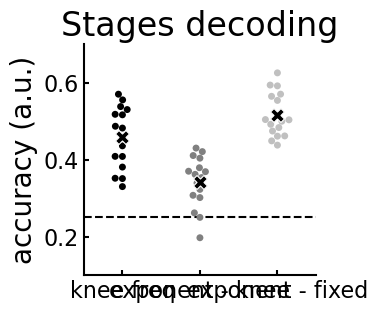

In [9]:
array_list6 = [accuracy_knee,accuracy_K, accuracy_F]
colors = ['black', 'grey', 'silver']

import seaborn
titles =  ['knee freq','exponent - knee','exponent - fixed']


ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list6, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list6,1), marker='X', color='black', s=100, zorder=4, legend=False);
ax.axhline(y=0.25, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(0.1, 0.7)
plt.xlim(-0.5, 2.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_decoding.svg", dpi = 600)

## Statistics
### Permutation stats against chance level

In [8]:
# FIRST PERMUTATION
ACC = [accuracy_knee,accuracy_K, accuracy_F]

# Specify the number of permutations
num_permutations = 100000 # number of permutations
n_regions = 16 # no of regions included
chance_l = 0.25 # 4 classes 
tvalue=np.zeros(3)
pvalue=np.zeros(3)
cohend=np.zeros(3)
for i in np.arange(len(ACC)):
    X = ACC[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(n_regions)*chance_l, num_permutations)


pvalue_bonf = pvalue * len(ACC)


# Create a DataFrame to store the results
results_table = pd.DataFrame({
    "Metric": ["Accuracy Knee", "Accuracy K", "Accuracy F"],
    "T-Value": tvalue,
    "P-Value (Bonferroni)": pvalue_bonf,
    "Cohen's D": cohend
})

# Save the table to a CSV file
file_path = "permutation_test_results.csv"
results_table.to_csv('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_stats_chance.svg', index=False)

# show stats
pvalue_bonf, tvalue, cohend

(array([0., 0., 0.]),
 array([10.56998945,  5.61454379, 18.27745624]),
 array([3.73705561, 1.985041  , 6.46205662]))

### Stats (Friedmann) between parameters

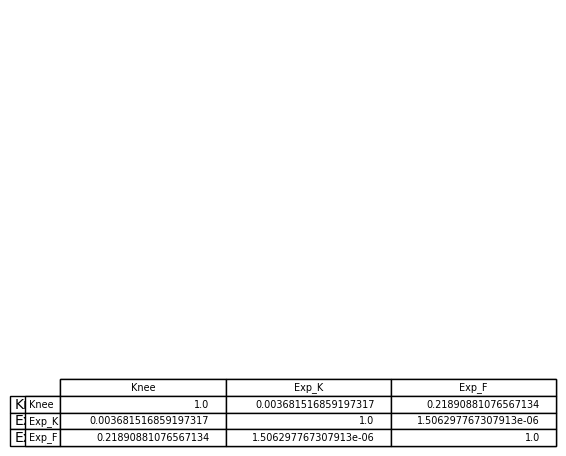

In [9]:
# Decoding stats repeated measures
data = pd.DataFrame(np.transpose(ACC))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

# Change the column names
effect_sizes.columns =['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.columns = ['Knee', 'Exp_K', 'Exp_F']
# Change the row indexes
effect_sizes.index = ['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.index = ['Knee', 'Exp_K', 'Exp_F']

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, effect_sizes)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_effectS.svg')

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, corrected_p_values)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_Pvalues.svg')

In [13]:
z_values, corrected_p_values, effect_sizes 

(array([[2.78291642e-16, 3.23248814e+00, 1.79302077e+00],
        [3.23248814e+00, 2.78291642e-16, 5.02550891e+00],
        [1.79302077e+00, 5.02550891e+00, 2.78291642e-16]]),
            Knee     Exp_K     Exp_F
 Knee   1.000000  0.003682  0.218909
 Exp_K  0.003682  1.000000  0.000002
 Exp_F  0.218909  0.000002  1.000000,
            Knee     Exp_K    Exp_F
 Knee        NaN  0.703125 -0.40625
 Exp_K -0.703125       NaN     -1.0
 Exp_F   0.40625       1.0      NaN)

# Using a Random Forest appraoch to see which parameter (Exponent Fixed, Exponent Knee, or Knee Frequency) predicts stages best

In [242]:
# Reset seed for replicability
random.seed(0)
np.random.seed(0)

# Add empty lists for results
accuracy_KE = []
perm_importance_results = []

# Set up cross-validation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Sample equal number of trials for each stage
def sample_data(data):
    return np.random.choice(data, L, replace=False)

# Loop over subjects
for i in range(38):
    ##################################################
    # DATA
    W_exp = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee = W_Kn[i][~np.isnan(W_Kn[i])]

    N2_exp = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee = N2_Kn[i][~np.isnan(N2_Kn[i])]

    N3_exp = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee = N3_Kn[i][~np.isnan(N3_Kn[i])]

    R_exp = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee = R_Kn[i][~np.isnan(R_Kn[i])]

    ###################################################
    # Equate the number of trials per stage
    L = min(map(len, [W_exp, N2_exp, N3_exp, R_exp, W_knee, N2_knee, N3_knee, R_knee]))

    # Skip regions with less than 25 trials
    if L < 25:
        continue

    W_exp, N2_exp, N3_exp, R_exp = map(sample_data, [W_exp, N2_exp, N3_exp, R_exp])
    W_knee, N2_knee, N3_knee, R_knee = map(sample_data, [W_knee, N2_knee, N3_knee, R_knee])

    # Labels for sleep stages
    y = np.concatenate([np.ones(L) * i for i in range(1, 5)])

    ###################################################
    # Combine features for knee and exponent
    X = np.column_stack([
        np.concatenate([W_exp, N2_exp, N3_exp, R_exp]),
        np.concatenate([W_knee, N2_knee, N3_knee, R_knee])
    ])

    ###################################################
    # Random Forest Classification with Proper Cross-Validation for Feature Importance
    fold_importances = []
    fold_accuracies = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        classifier = RandomForestClassifier(n_estimators=500, max_features=1, random_state=42)
        classifier.fit(X_train, y_train)

        # Compute accuracy for this fold
        fold_accuracies.append(classifier.score(X_test, y_test))

        # Compute permutation importance **only on test set** (avoids data leakage)
        perm_importance = permutation_importance(
            classifier, X_test, y_test, n_repeats=1000, random_state=42, scoring='accuracy'
        )
        fold_importances.append(perm_importance.importances_mean)

    # Store the mean accuracy across folds
    accuracy_KE.append(np.mean(fold_accuracies))

    # Store the mean importance across folds
    perm_importance_results.append(np.mean(fold_importances, axis=0))

###################################################
# Aggregate Results
mean_accuracy = np.mean(accuracy_KE)
std_accuracy = np.std(accuracy_KE)
perm_importance_results = np.array(perm_importance_results)
mean_perm_importance = np.mean(perm_importance_results, axis=0)
sem_perm_importance = np.std(perm_importance_results, axis=0) / np.sqrt(len(mean_perm_importance))


### Plot Feature importance 

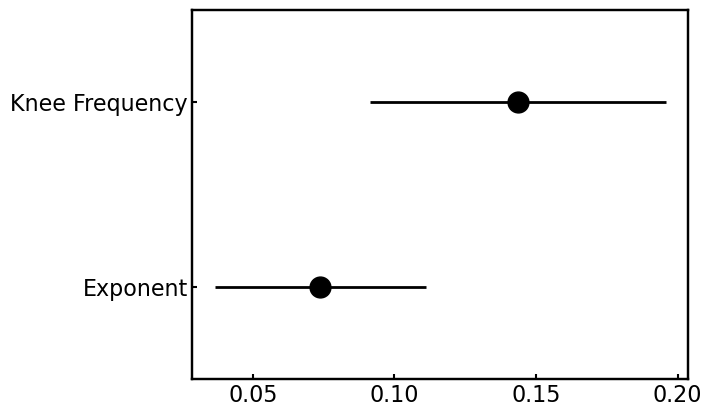

In [243]:
fig, ax = plt.subplots()
titles = ['Exponent', 'Knee Frequency']
ax.set_ylim([-0.5, 1.5])
ax.errorbar(mean_perm_importance, [0, 1], xerr=sem_perm_importance, fmt="o", markersize=15, 
             elinewidth=2, color='k')
ax.yaxis.set_ticks(np.arange(2))
ax.set_yticklabels(titles)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_featureImp.svg", dpi = 600)


### Stats on feature importance (t-test)

In [244]:
from scipy.stats import ttest_rel
# Function for Cohen's d
def cohens_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

# Perform paired t-test between feature importances
t_stat, p_value = ttest_rel(perm_importance_results[:, 0], perm_importance_results[:, 1])

# Compute Cohen's d
d_effect_size = cohens_d(perm_importance_results[:, 0], perm_importance_results[:, 1])


In [245]:
from scipy.stats import ttest_rel, shapiro, wilcoxon

# Function for Cohen's d
def cohens_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

# Test for normality
stat_x, p_x = shapiro(perm_importance_results[:, 0])
stat_y, p_y = shapiro(perm_importance_results[:, 1])

if p_x > 0.05 and p_y > 0.05:
    # Perform paired t-test between feature importances
    t_stat, p_value = ttest_rel(perm_importance_results[:, 0], perm_importance_results[:, 1])
    
    # Compute Cohen's d
    d_effect_size = cohens_d(perm_importance_results[:, 0], perm_importance_results[:, 1])
else:
    # Perform Wilcoxon signed-rank test (non-parametric alternative)
    t_stat, p_value = wilcoxon(perm_importance_results[:, 0], perm_importance_results[:, 1])
    d_effect_size = None  # Cohen's d is not defined for Wilcoxon

# Print statistical results
print(f"Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"T-test between feature importances: t={t_stat:.3f}, p={p_value:.3f}")
print(f"Cohen's d effect size: {d_effect_size:.3f}")

Mean Accuracy: 0.457 ± 0.084
T-test between feature importances: t=-5.132, p=0.000
Cohen's d effect size: -1.056
